In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
import joblib
import logging
import optuna
from causalml.metrics.visualize import get_cumgain
from causalml.metrics import auuc_score
from causalml.inference.tree import UpliftRandomForestClassifier

%load_ext autoreload
%aimport plotMethods
%autoreload 1

np.random.seed(42) 

# Uplift modeling - which customers to target?

Modern world is full of advertisements and those are becoming more and more targeted. To win our attention, companies adapt to e.g. our digital viewing habits, collect our demographic data and then use this information to sell us things they think we may like. By focusing on specific traits, interests and preferences of a customer, targeted marketing is trying to **maximize the incremental impact of the promoted product**.

But how do these marketing campaigns identify the right individuals to send discount coupons or personalized advertisements to? Certainly, running those campaigns incurs financial costs, and it is unfeasible to send discount coupons to everyone in the world. The cost of printing the coupons and the lost of potential revenues, resulting from the offered discount, might just outweigh the additional profits generated from new customers. In addition, what if the customer was already planning to buy the advertised coupon, without receiving any extra discounts or adverts? In that case, the retailer would generate less profit, as the customer will be paying less than what they already intended to pay. So how do you identify individuals who are **only likely to purchase** your product **if targeted by the marketing campaign**?

## Dataset

Here, we will be using data provided by *Udacity* as part of their *Data Scientist Nanodegree*. This dataset was originally used as a take-home assignment given out by Starbucks during job application process. The data consists of about 120,000 data points split in a 2:1 ratio between training and testing sets. In the experiment, simulated by the data, Starbucks is about to launch a new marketing campaign based on sending promotional materials to selected customers. The team has run a randomized pilot (A/B testing) to test this campaign. In the pilot, a subset of customers was divided into two groups, only one of which received the promotion. The team recorded each customer's buying decision along with 7 features (*V1-V7*) encoding their personal characteristics. Based on the gathered data, we now want to know which other customers should be assigned to this campaign, in a way that would maximize generated profit. Since it costs the company *0.15* to contact each person, it would be best to limit the campaign only to the most receptive customers. As such, rather than predicting which customers would buy the product, we want to predict which customers would buy the product **only if contacted** (interaction).

## Goal

Our goal is to maximize the **profit of the campaign**:

$profit = \sum \limits _{i=1} ^{N} 10*purchase_{i}(decision_{i}) - 0.15*decision_{i}$,

where *purchase* is a purchasing decision of an individual client influenced by the *decision* - a binary indicator of whether that person has been targeted or not.

To account for the fact that some customers buy the product even if not targeted, we should also look at the **net incremental profit**, defined as:

$NIR = profit-10*nControlPurchase$,

where *nControlPurchase* is the number of people, who were not targeted and bought the service.

Furthermore, Starbucks asked their job candidates to also optimize the **incremental response rate**, defined as:

$IRR = \frac{nTreatPurchase}{nTreat} - \frac{nControlPurchase}{nControl}$, 

where *nTreatPurchase* is the number of people, who were not targeted and bought the service; and *nTreat* and *nControl* are the number of targeted and non-targeted customers respectively.

For this assignment, Starbucks claimed to have a model that achieved a NIR of 189.45 and an IRR of 1.88%. Note that this assignment is quite outdated though and it is very likely that Starbucks will have a better model now! Yet, these numbers will serve us as the benchmarks to beat.

## The approach

The problem of deciding whether it is profitable to target a particular customer can be tackled from two different perspectives:

1. traditional predictive modeling, where the problem is treated as a common classification task
2. uplift modeling, where the incremental probability of purchase is modeled

Here, we're going to compare both of those perspectives and use a total of four different approaches to choosing which customers to target:

0. [Exploratory data analysis](./0.EDA.ipynb)
1. [Traditional predictive model](./1.Classical-predictive-models.ipynb) 
2. [S-learner model (one-model "uplift classifier")](./2.S-learner.ipynb)
3. [T-learner model (two-models "uplift classifier")](./3.T-learner.ipynb) 
4. Direct uplift modeling

# Direct uplift modeling

Estimating uplift directly requires modifying existing machine learning algorithms to optimize for uplift. The most commonly used direct uplift models are based on Decision Trees [(Rzepakowski & Jarosiewicz, 2012)](https://link.springer.com/article/10.1007/s10115-011-0434-0) and Random Forests [(Zhao, Fang & Simchi-Levi, 2017)](https://arxiv.org/pdf/1705.08492.pdf). Here we're going to use the Causal Uplift Forest as implemented in the *causalml* package.

In [4]:
data = pd.read_csv("data/training.csv")
data['Promotion'] = data['Promotion'].replace({'No': 0, 'Yes': 1})
data.columns = ['ID', 'promotion', 'purchase', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

## Modeling

We will use the *purchase* column as the target that we want to predict. To quantify the performance of our models, we are going to split our dataset into training and dev (test) subsets and use cross-validation to tune some of the models' parameters.

In [6]:
features = list(data.iloc[:,3:].select_dtypes(exclude='object').columns) + ['promotion']
X = data[features]
y = data.purchase
Xtrain, Xtest, Ytrain, Ytest, Ttrain, Ttest = train_test_split(X, y, data.promotion, test_size=0.1, stratify=y, random_state=42)

To reduce the computational load a bit, I am going to downsample the training set before tuning the hyperparameters. After choosing the hyperparameters, the model will be retrained on all the training data, but to make my computer's life a little bit easier, I am going to tune the hyperparameters based on 20000 observations. I will only be removing the observations coming from people that did not purchase the product.

In [7]:
NoPurch = data.query('purchase == 0').index
commonIdx = list(set(NoPurch).intersection(Xtrain.index))
toDrop = np.random.choice(commonIdx, 56080, replace=False)
Xhyper = Xtrain.drop(toDrop)
Yhyper = Ytrain.drop(toDrop)
Thyper = Ttrain.drop(toDrop)

In [8]:
plotMethods.eda(Xhyper)

,type,count,missing,unique,mean,std,min,max,kurtosis,skew
V1,int64,20000,0,4,1.501800,0.867199,0.000000,3.000000,-0.670078,-0.001857
V2,float64,20000,0,19999,29.935364,5.004820,8.939305,48.615385,0.059210,-0.009445
V3,float64,20000,0,40,-0.000240,0.998665,-1.684550,1.691984,-1.200688,-0.007022
V4,int64,20000,0,2,1.680050,0.466469,1.000000,2.000000,-1.404083,-0.772048
V5,int64,20000,0,4,2.333000,0.848615,1.000000,4.000000,-0.770349,-0.073673
V6,int64,20000,0,4,2.510450,1.114519,1.000000,4.000000,-1.351707,-0.014541
V7,int64,20000,0,2,1.700650,0.457985,1.000000,2.000000,-1.232191,-0.876318
promotion,int64,20000,0,2,0.506200,0.499974,0.000000,1.000000,-1.999585,-0.024804


In [9]:
bestFeatures = SelectKBest(mutual_info_classif, k='all')
bestFeatures.fit(Xtrain, Ytrain)
bestFeatures.scores_

array([0.00530275, 0.00060949, 0.00118218, 0.01115713, 0.00587156,
       0.00436519, 0.01114072, 0.00580228])

Because our dataset is still **unbalanced**, instead of downsampling even more, we are going to use oversampling technique called **SMOTE**. SMOTE synthetically generates new data points belonging to the minority class.

In [10]:
numPipe = StandardScaler()
preproc = ColumnTransformer(transformers=[('num', numPipe, Xtrain.select_dtypes(include="number").columns.drop('promotion')),
                                         ('pass', 'passthrough', ['promotion'])])
oversamp = SMOTE()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
def objective(trial):
    
    upliftParams = {
        "n_estimators": 200, 
        "max_depth": trial.suggest_int("max_depth", 5, 15), 
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 20, 120),
        "min_samples_treatment": trial.suggest_int("min_samples_treatment", 5, 50),
        "n_reg": 10,
        "evaluationFunction": 'KL',
        "control_name": 'control',
    }
    
    model = UpliftRandomForestClassifier(**upliftParams)
    score = 0
    
    for indexTrain, indexTest in skf.split(Xhyper, Yhyper):
        model = UpliftRandomForestClassifier(**upliftParams)
        Xcross, Tcross, Ycross = Xhyper.iloc[indexTrain,:], Thyper.iloc[indexTrain], Yhyper.iloc[indexTrain]
        Xval, Tval, Yval = Xhyper.iloc[indexTest,:], Thyper.iloc[indexTest], Yhyper.iloc[indexTest]
        Xcross = preproc.fit_transform(Xcross)
        Over = oversamp.fit_resample(Xcross, Ycross)
        model.fit(Over[0][:,0:7], np.where(Over[0][:,7] == 0, 'control', 'treat'), y=np.array(Over[1]))
        Xval = preproc.transform(Xval)
        upliftPred = model.predict(X=np.array(Xval[:,0:7]))
        score += auuc_score(pd.DataFrame({'y': np.array(Yval), 'w': np.array(Tval), 'uplift': upliftPred.reshape(-1)}), normalize=True)[0]
        print(score)
    
    cross_score = score/5
    
    return cross_score

As this model is rather computationally heavy to train, I am going to only train it for 10 trials. Note, that longer training could improve the performance of the model.

In [ ]:
upStudy = optuna.create_study(direction='maximize')
upStudy.optimize(objective, n_trials=10)

joblib.dump(upStudy, 'models/direct-uplift')  # save model

In [14]:
upStudy = joblib.load('models/direct-uplift')
model = UpliftRandomForestClassifier(max_depth=upStudy.max_deepth,
                                     min_samples_leaf=upStudy.min_sample_leaf,
                                     min_samples_treatment=upStudy.min_samples_treatment,
                                     n_estimators=200, n_reg=10, evaluationFunction='KL',
                                     control_name='control')
XtrainPreproc = preproc.fit_transform(Xtrain)
Over = oversamp.fit_resample(XtrainPreproc, Ytrain)
model.fit(Over[0][:,0:7], np.where(Over[0][:,7] == 0, 'control', 'treat'), y=np.array(Over[1]))
joblib.dump(model, 'models/direct-uplift-trained') 

['models/direct-uplift-trained']

In [15]:
XtestPreproc = preproc.transform(Xtest)
uplift = model.predict(X=np.array(XtestPreproc[:,0:7]))

In [16]:
Xuplift = Xtest.copy()
Xuplift['uplift'] = uplift
Xuplift['Y'] = Ytest

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


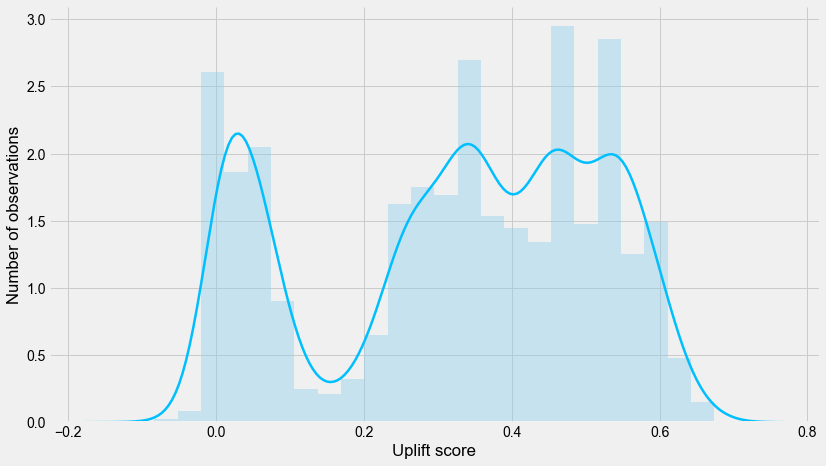

In [17]:
fig, ax = plt.subplots(figsize=(12,7))
plt.style.use("seaborn-white")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
sns.distplot(uplift, kde_kws = {"color": "deepskyblue"}, hist_kws = {"color": "skyblue"}, ax=ax)
sns.despine()
plt.xlabel('Uplift score')
plt.ylabel('Number of observations')

plt.tight_layout()

The distribution of uplift is mostly positive, which makes sense since we know from our A/B testing analysis that sending out promotions does increase the number of purchases on average.
Unlike with the previous models, we do not see many observations with negative uplift scores.

Interestingly the distribution seems to be multinomial, with at least two distinct peaks.

Text(0, 0.5, 'True uplift')

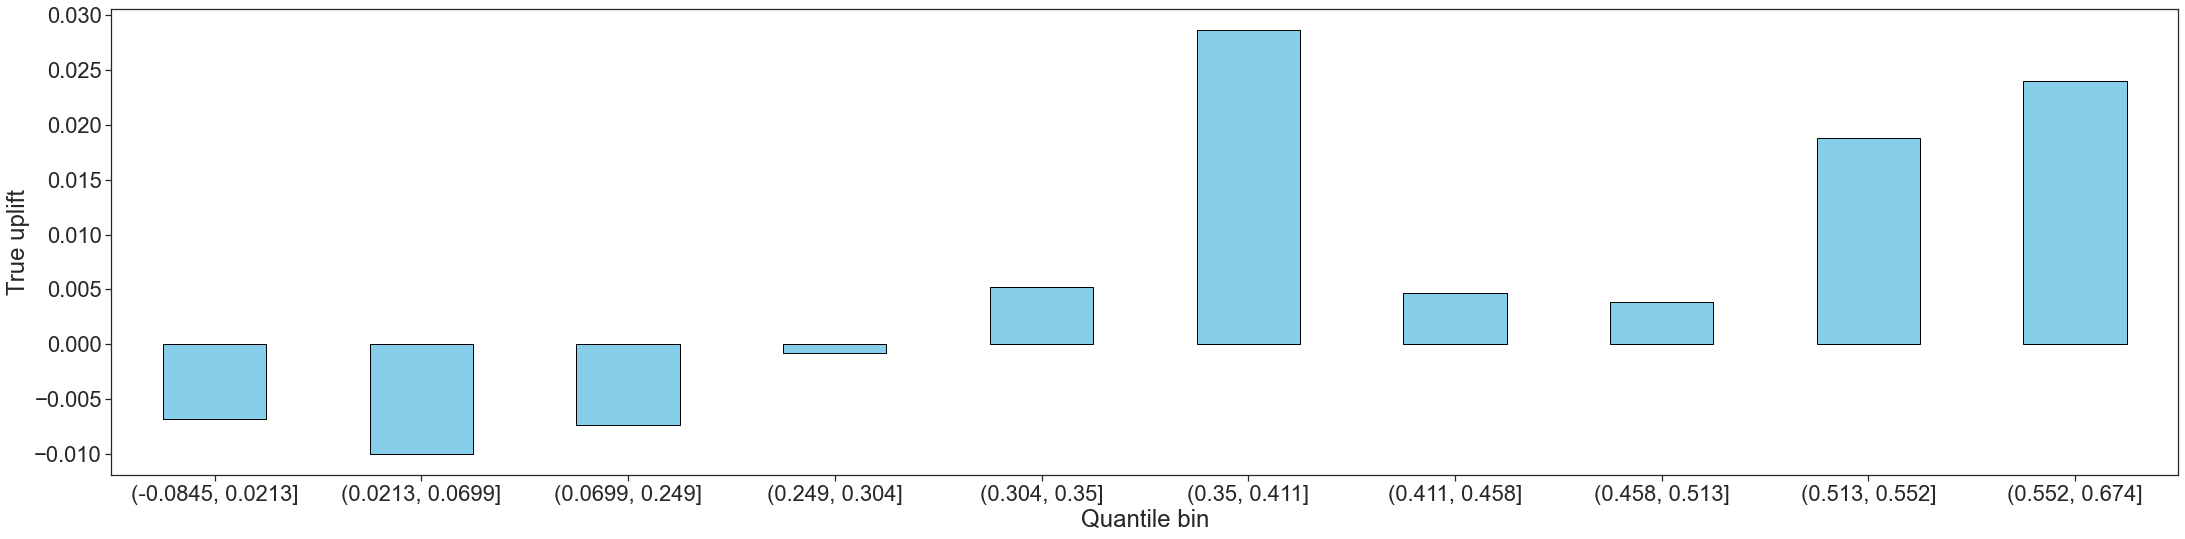

In [18]:
upliftQuant, upliftQuant_bins = pd.qcut(x=Xuplift['uplift'], q=10, retbins=True, duplicates='drop')
Xuplift['quant'] = upliftQuant
QuantTarget = Xuplift.query('promotion == 1').groupby('quant')['Y'].mean()
QuantControl = Xuplift.query('promotion == 0').groupby('quant')['Y'].mean()
quantUp = QuantTarget - QuantControl

fig, ax = plt.subplots(figsize=(33,8))
quantUp.plot(kind="bar", stacked=True, color="skyblue", edgecolor='black')
plt.xticks(rotation=0)
plt.xlabel('Quantile bin')
plt.ylabel('True uplift')

The uplift quantile chart shows that, for the most part, true uplift increases from lower score bins to higher ones, which is what we would expect to see if the model is working. So it appears our model can, at least to some extent, segment out customers who more readily respond to the marketing campaign. 

What else can we learn from the quantile chart? From analysis of the A/B testing we know the IIR is about 1%. The quantile chart we created with the validation set tells us that by targeting the top decile of the uplift scores, **we could potentially achieve a treatment effect of around 2.5%**. The next few deciles appear to have larger treatment effects than our original IIR as well. It thus may make the most sense to **only target customers within the top 5 deciles** of uplift scores.

We can also see that the *sleeping dog effect* has some support from observations of the true uplift. The bottom score deciles, consisting entirely of negative scores, have a negative true uplift. So it appears that targeting the bottom 30% of the population, by uplift score, would actually have a negative impact on the business. 

Let's also check the cumulative gain plot and calculate our AUUC metric, so that we can compare this model to the other ones.

Text(0, 0.5, 'Cumulative gain')

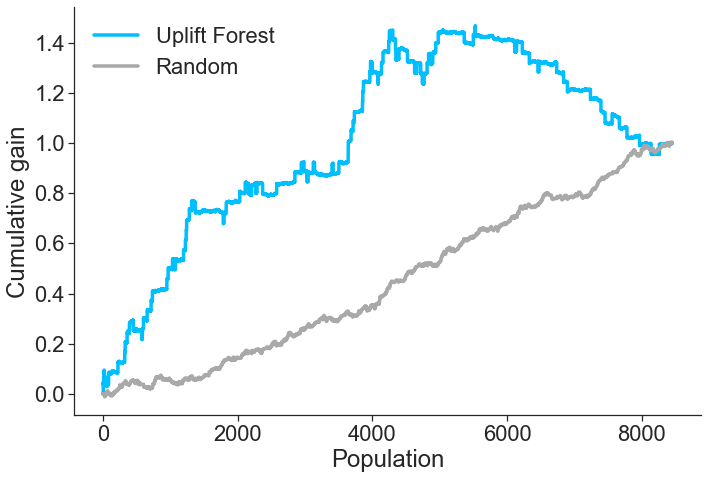

In [19]:
gain = get_cumgain(Xuplift[['uplift', 'Y', 'promotion']], outcome_col='Y', treatment_col='promotion', normalize=True)
gain.columns = ['Uplift Forest', 'Random']
fig, ax = plt.subplots(figsize=(10,7))
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3.5})
sns.lineplot(data=gain, palette={'Random': 'darkgray', 'Uplift Forest': 'deepskyblue'}, dashes=False, ax=ax)
sns.despine()
plt.xlabel("Population")
plt.ylabel("Cumulative gain")

In [20]:
AUUC = auuc_score(Xuplift[['uplift', 'Y', 'promotion']], outcome_col='Y', treatment_col='promotion', normalize=True)
print("Random AUUC: {:.3f}\nUplift Forest {:.3f}".format(AUUC[1], AUUC[0]))

Random AUUC: 0.447
Uplift Forest 0.994


Our uplift model performs much better than random targeting! Let's check what NIR and IIR we would generate if we targeted the first 2 deciles of our validation set. In order to check that we're going to discard people who were not targeted and did not buy the product from our validation set. This is due to the fact that we do not have ground truth scenario for how they would behave if we targeted them.

In [21]:
toDrop = Xuplift.query('promotion == 0 and Y == 0').index
NoPurchValid = Xuplift.drop(toDrop)
plotMethods.eda(NoPurchValid)

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,type,count,missing,unique,mean,std,min,max,kurtosis,skew
V1,int64,4321,0,4,1.504050,0.866851,0,3,-0.668249,-0.005001
V2,float64,4321,0,4321,30.016632,5.052259,10.389459,49.772803,0.026512,0.011639
V3,float64,4321,0,40,0.013525,0.992774,-1.68455,1.691984,-1.198498,-0.006148
V4,int64,4321,0,2,1.669521,0.470440,1,2,-1.480809,-0.721025
V5,int64,4321,0,4,2.312428,0.838349,1,4,-0.767420,-0.069009
V6,int64,4321,0,4,2.503587,1.119709,1,4,-1.363726,-0.003037
V7,int64,4321,0,2,1.697755,0.459284,1,2,-1.258324,-0.861544
promotion,int64,4321,0,2,0.990974,0.094585,0,1,105.927902,-10.386475
uplift,float64,4321,0,2158,0.322540,0.191990,-0.057317,0.673799,-1.114948,-0.343648
Y,int64,4321,0,2,0.024069,0.153280,0,1,36.616484,6.212852


In [24]:
profit = plotMethods.incremental_profit_score(NoPurchValid['Y'], (NoPurchValid['uplift']>0.513).astype(int))
IIR = plotMethods.IRRscore(NoPurchValid['Y'], (NoPurchValid['uplift']>0.513).astype(int))
print("NIR: {:.2f}\nIIR {:.2f}%".format(profit, IIR*100))

NIR: 152.00
IIR 1.11%


The original A/B testing, targeted at random around 50% of the sample group, generating IIR of 1%.
This uplift model targets a smaller proportion of population, generating slightly higher IIR.

1. [Traditional predictive model](./1.Classical-predictive-models.ipynb)
2. [S-learner model](./2.S-learner.ipynb)
3. [T-learner model (two-models "uplift classifier")](./3.T-learner.ipynb)